# 第四章 基础实战——FashionMNIST时装分类

<img src="./fashion-mnist-sprite.png" width="400" />  
<table>
<thead>
<tr>
<th>Label</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>T-shirt/top</td>
</tr>
<tr>
<td>1</td>
<td>Trouser</td>
</tr>
<tr>
<td>2</td>
<td>Pullover</td>
</tr>
<tr>
<td>3</td>
<td>Dress</td>
</tr>
<tr>
<td>4</td>
<td>Coat</td>
</tr>
<tr>
<td>5</td>
<td>Sandal</td>
</tr>
<tr>
<td>6</td>
<td>Shirt</td>
</tr>
<tr>
<td>7</td>
<td>Sneaker</td>
</tr>
<tr>
<td>8</td>
<td>Bag</td>
</tr>
<tr>
<td>9</td>
<td>Ankle boot</td>
</tr>
</tbody>
</table>


经过前面三章内容的学习，我们完成了以下的内容：  
- 对PyTorch有了初步的认识
- 学会了如何安装PyTorch以及对应的编程环境
- 学习了PyTorch最核心的理论基础（张量&自动求导）
- 梳理了利用PyTorch完成深度学习的主要步骤和对应实现方式  
  
现在，我们通过一个基础实战案例，将第一部分所涉及的PyTorch入门知识串起来，便于大家加深理解。同时为后续的进阶学习打好基础。 
  
我们这里的任务是对10个类别的“时装”图像进行分类，使用FashionMNIST数据集（https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion ）。上图给出了FashionMNIST中数据的若干样例图，其中每个小图对应一个样本。  
FashionMNIST数据集中包含已经预先划分好的训练集和测试集，其中训练集共60,000张图像，测试集共10,000张图像。每张图像均为单通道黑白图像，大小为32\*32pixel，分属10个类别。  
  
下面让我们一起将第三章各部分内容逐步实现，来跑完整个深度学习流程。

**首先导入必要的包**  

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

**配置训练环境和超参数**  


In [2]:
# 配置GPU，这里有两种方式
## 方案一：使用os.environ
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 4   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20

**数据读入和加载**  
这里同时展示两种方式:  
- 下载并使用PyTorch提供的内置数据集  
- 从网站下载以csv格式存储的数据，读入并转成预期的格式    
第一种数据读入方式只适用于常见的数据集，如MNIST，CIFAR10等，PyTorch官方提供了数据下载。这种方式往往适用于快速测试方法（比如测试下某个idea在MNIST数据集上是否有效）  
第二种数据读入方式需要自己构建Dataset，这对于PyTorch应用于自己的工作中十分重要  
  
同时，还需要对数据进行必要的变换，比如说需要将图片统一为一致的大小，以便后续能够输入网络训练；需要将数据格式转为Tensor类，等等。
  
这些变换可以很方便地借助torchvision包来完成，这是PyTorch官方用于图像处理的工具库，上面提到的使用内置数据集的方式也要用到。PyTorch的一大方便之处就在于它是一整套“生态”，有着官方和第三方各个领域的支持。这些内容我们会在后续课程中详细介绍。

In [3]:
# 首先设置数据变换
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    # transforms.ToPILImage(),   # 这一步取决于后续的数据读取方式，如果使用内置数据集则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [4]:
## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
from torchvision import datasets

ROOT_DIR = '../../data/'
train_data = datasets.FashionMNIST(root=ROOT_DIR, train=True, download=True, transform=data_transform)
test_data = datasets.FashionMNIST(root=ROOT_DIR, train=False, download=True, transform=data_transform)
classes = np.array(["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"])

在构建训练和测试数据集完成后，需要定义DataLoader类，以便在训练和测试时加载数据  


In [5]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

读入后，我们可以做一些数据可视化操作，主要是验证我们读入的数据是否正确

torch.Size([256, 1, 28, 28]) torch.Size([256])


(-0.5, 27.5, 27.5, -0.5)

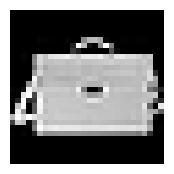

In [6]:
import matplotlib.pyplot as plt

image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.figure(figsize=(2,2))
plt.imshow(image[0][0], cmap="gray")
plt.axis('off')

**模型设计**  
由于任务较为简单，这里我们手搭一个CNN，而不考虑当下各种模型的复杂结构  
模型构建完成后，将模型放到GPU上用于训练  


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
model = model.cuda()
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法，之后的课程中会进一步讲解


(dot.exe:48992): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


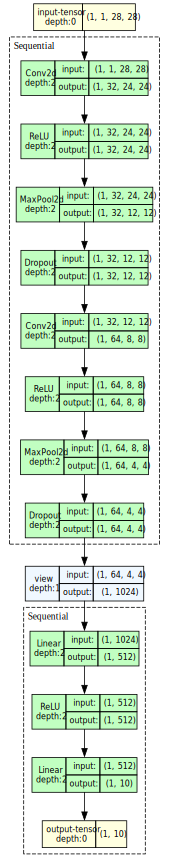

In [8]:
from torchview import draw_graph

batch_size = 1
model_graph = draw_graph(model, input_size=(batch_size, 1, 28, 28), expand_nested=True) # device='meta', 
model_graph.visual_graph

**设定损失函数**  
使用torch.nn模块自带的CrossEntropy损失  
PyTorch会自动把整数型的label转为one-hot型，用于计算CE loss  
这里需要确保label是从0开始的，同时模型不加softmax层（使用logits计算）,这也说明了PyTorch训练中各个部分不是独立的，需要通盘考虑

In [9]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=[1,1,1,1,3,1,1,1,1,1])

**设定优化器**  
这里我们使用Adam优化器  

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

**训练和测试（验证）**  
各自封装成函数，方便后续调用  
关注两者的主要区别：  
- 模型状态设置  
- 是否需要初始化优化器
- 是否需要将loss传回到网络
- 是否需要每步更新optimizer  
  
此外，对于测试或验证过程，可以计算分类准确率

In [11]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [12]:
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [13]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.659762
Epoch: 1 	Validation Loss: 0.445224, Accuracy: 0.832000
Epoch: 2 	Training Loss: 0.410085
Epoch: 2 	Validation Loss: 0.374410, Accuracy: 0.866600
Epoch: 3 	Training Loss: 0.353276
Epoch: 3 	Validation Loss: 0.322309, Accuracy: 0.884000
Epoch: 4 	Training Loss: 0.317720
Epoch: 4 	Validation Loss: 0.301647, Accuracy: 0.890300
Epoch: 5 	Training Loss: 0.297931
Epoch: 5 	Validation Loss: 0.297034, Accuracy: 0.891500
Epoch: 6 	Training Loss: 0.280493
Epoch: 6 	Validation Loss: 0.279212, Accuracy: 0.895800
Epoch: 7 	Training Loss: 0.268811
Epoch: 7 	Validation Loss: 0.260550, Accuracy: 0.905000
Epoch: 8 	Training Loss: 0.257210
Epoch: 8 	Validation Loss: 0.254875, Accuracy: 0.905900
Epoch: 9 	Training Loss: 0.246411
Epoch: 9 	Validation Loss: 0.269879, Accuracy: 0.900200
Epoch: 10 	Training Loss: 0.238834
Epoch: 10 	Validation Loss: 0.250345, Accuracy: 0.906900
Epoch: 11 	Training Loss: 0.227353
Epoch: 11 	Validation Loss: 0.246728, Accuracy: 0.910300
Epoch:

**模型预测**  

truth: 
 [9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2 3 6 7 2 7 8 5 9 9 4 2
 5 7 0 5 2 8 6 7 8 0 0 9 9 3 0 8 4 1 5 4 1 9 1 8 6 2 1 2 5 1 0 0 0 1 6 1 6
 2 2 4 4 1 4 5 0 4 7 9 3 7 2 3 9 0 9 4 7 4 2 0 5 2 1 2 1 3 0 9 1 0 9 3 6 7
 9 9 4 4 7 1 2 1 6 3 2 8 3 6 1 1 0 2 9 2 4 0 7 9 8 4 1 8 4 1 3 1 6 7 2 8 5
 2 0 7 7 6 2 7 0 7 8 9 2 9 0 5 1 4 4 5 6 9 2 6 8 6 4 2 2 9 7 6 5 5 2]
prediction: 
 [9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 6 8 0 2 5 7 5 1 2 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 0 1 6 9 6 7 2 1 6 6 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 6 4 7 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 2 2 3 6 7 2 7 8 5 9 9 4 2
 5 7 0 5 2 8 6 7 8 0 0 9 9 3 0 8 4 1 5 4 1 9 1 8 4 2 1 2 5 1 0 0 0 1 6 1 3
 2 2 3 4 1 4 5 0 4 7 9 3 7 2 3 9 0 9 4 7 4 2 0 5 2 1 2 1 3 0 9 1 0 9 3 6 7
 9 9 4 4 7 1 2 1 6 3 2 8 3 6 1 1 0 2 9 2 4 0 7 9 8 4 1 8 4 1 3 1 6 7 2 8 5
 2 0 7 

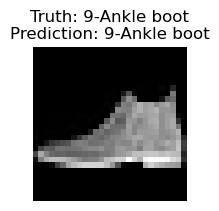

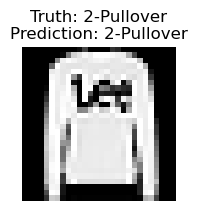

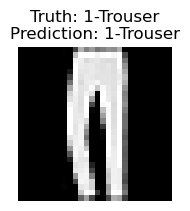

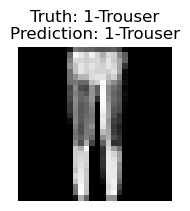

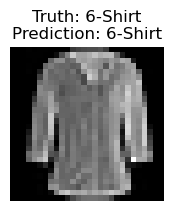

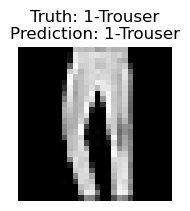

In [16]:
# 测试1个batch
data, label = next(iter(test_loader))

data, label = data.cuda(), label.cuda()
output = model(data)
preds = torch.argmax(output, 1)
print("truth: \n", label.cpu().data.numpy()) # [str(idx)+"-"+classes[idx] for idx in label.cpu().data.numpy()]) 
print("prediction: \n", preds.cpu().data.numpy()) # [str(idx)+"-"+classes[idx] for idx in preds.cpu().data.numpy()]) 

show_items = 0
for img, t, p in zip(data.cpu().squeeze(1), 
                     [str(idx)+"-"+classes[idx] for idx in label.cpu().data.numpy()], 
                     [str(idx)+"-"+classes[idx] for idx in preds.cpu().data.numpy()]):    
    if show_items > 5:
        break
        
    plt.figure(figsize=(2,2))
    plt.title("Truth: " + t + "\n" + "Prediction: " + p)
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.show()
    
    show_items += 1

**模型保存**  
训练完成后，可以使用torch.save保存模型参数或者整个模型，也可以在训练过程中保存模型  
这部分会在后面的课程中详细介绍